# Agent

Agents are systems that use LLMs as reasoning engines to determine which actions to take and the inputs to pass them. After executing actions, the results can be fed back into the LLM to determine whether more actions are needed, or whether it is okay to finish.

代理是使用大型語言模型（LLMs）作為推理引擎來決定採取哪些行動以及傳遞哪些輸入的系統。執行行動後，結果可以回饋到大型語言模型中，以確定是否需要更多的行動，或者是否可以結束。


- Based on the prompt, Agent creates an LLM based 'Thought': what it should do
- Based on the 'Thought', Angent takes 'Action'.

## Agent Tools:

- API services: OpenAI Whisper-1, TTS-1, DALLE3, Google Search
- Precision matters: Mathematics, Scientific Calculation
- Extra knowledge: Wikipedia, Private Dataset

In [1]:
from IPython.display import Image

Image(url='https://statusneo.com/wp-content/uploads/2024/01/fe9fa1ac-dfde-4d91-8b5b-4497b742c414_1400x686.jpg')

In [2]:
import os

os.chdir("../../../")

## Model + Tools

Tool calling allows a chat model to respond to a given prompt by "calling a tool". While the name implies that the model is performing some action, this is actually not the case! The model generates the arguments to a tool, and actually running the tool (or not) is up to the user. For example, if you want to extract output matching some schema from unstructured text, you could give the model an "extraction" tool that takes parameters matching the desired schema, then treat the generated output as your final result.

In [3]:
from langchain_openai import ChatOpenAI
from src.initialization import credential_init

credential_init()

model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                   model_name="gpt-4o", temperature=0)

## Zero-Shot Agent

- PromptTemplate.from_template: This creates a template for the AI to follow when generating responses. A "zero-shot" prompt means the AI will generate answers without needing specific examples beforehand.

- create_react_agent: This function creates an AI agent using a specific language model (LLM). The agent can react to prompts based on the template provided.

- AgentExecutor: This sets up an executor that can run the agent. The verbose=True part means it will provide detailed output about what it’s doing.

- agent_executor.invoke: This runs the agent with the given input. In this case, it's asking the agent to calculate the area of a circle with a specified radius.

- PromptTemplate.from_template: 創建一個模板，供AI在生成回應時遵循。"zero-shot" 提示意味著AI在生成回答時不需要事先的具體示例。

- create_react_agent: 該函數使用特定的語言模型（LLM）創建一個AI代理。該代理可以根據提供的模板對提示做出反應。

- AgentExecutor: 設置一個執行器來運行代理。verbose=True部分意味著它會提供詳細的輸出。

- agent_executor.invoke: 這會運行具有給定輸入的代理。在此情況下，它是請求代理計算具有指定半徑的圓的面積。

## ZeroShot PromptTemplate

prompt_template = """
Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer

Thought: you should always think about what to do

Action: the action to take, should be one of [{tool_names}]

Action Input: the input to the action

Observation: the result of the action

... (this Thought/Action/Action Input/Observation can repeat N times)

Thought: I now know the final answer

Final Answer: the final answer to the original input question

Begin!

Question: {input}

Thought:{agent_scratchpad}
"""

In [4]:
from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor, create_react_agent

from src.agent.react_zero_shot import prompt_template as zero_shot_prompt_template

prompt = PromptTemplate(template=zero_shot_prompt_template)

zero_shot_agent = create_react_agent(
    llm=model,
    tools=[],
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=[], verbose=True)

In [ ]:
print(zero_shot_prompt_template)

In [ ]:
agent_executor.invoke({"input": "can you calculate the area of a circle that has a radius of 10.923mm"})

比較LLM輸出和真實數學運算結果上的差異

In [ ]:
import numpy as np

10.923 **2 * np.pi

In [ ]:
from typing import Annotated

from langchain_core.tools import tool

@tool
def circle_area(radius: Annotated[float, 'radius of a circle']) -> float:
    """Area of a circle."""
    return np.pi * float(radius) ** 2

In [ ]:
tools=[circle_area]

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True)

In [ ]:
agent_executor.invoke({"input": "can you calculate the area of a circle that has a radius of 10.923mm"})

https://python.langchain.com/docs/how_to/custom_tools/

Note that @tool supports parsing of annotations, nested schemas, and other features:

In [ ]:
from typing import Annotated, List


@tool
def multiply_by_max(
    a: Annotated[int, "scale factor"],
    b: Annotated[List[int], "list of ints over which to take maximum"],
) -> int:
    """Multiply a by the maximum of b."""

    print(a)
    print("************")
    print(b)

    
    return a * max(b)


print(multiply_by_max.args_schema.model_json_schema())

In [ ]:
tools=[multiply_by_max]

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True)

agent_executor.invoke({"input": "Please multiply the biggest number in a python list [3, 5, 7, 9, 11] by 5"})

In [ ]:
from typing import List

from pydantic import BaseModel, Field
from langchain_core.tools import StructuredTool


class CalculatorInput(BaseModel):
    a: int = Field(description="scale factor")
    b: List[int] = Field(description="list of ints over which to take maximum")


def multiply_by_max(a: int, b: List[int]) -> int:
    """Multiply a by the maximum of b."""
    return a * max(b)


calculator = StructuredTool.from_function(
    func=multiply_by_max,
    name="multiply_by_max",
    description="Multiply a by the maximum of b.",
    args_schema=CalculatorInput,
    return_direct=True,
    parse_docstring=True
    # coroutine= ... <- you can specify an async method if desired as well
)

print(calculator.invoke({"a": 5, "b": [3, 5, 7, 9, 11]}))

In [ ]:
# StructuredTool.from_function?

In [ ]:
tools=[calculator]

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True)

agent_executor.invoke({"input": "Please multiply the biggest number in a python list [3, 5, 7, 9, 11] by 5"})

It is super dumb. How to make it work?

### CircleAreaTool Class:

    - name: This sets the name of the tool to "Circle area calculator".
    - description: This provides a description of when to use the tool.
    - _run Method: This method performs the calculation of the area using the radius provided. It converts the radius to a float and calculates the area using the formula 

$$ \text{Area} = \pi \times \text{r}^2 $$

    - _arun Method: This raises an error because asynchronous operation is not supported by this tool.

In [ ]:
from math import pi
from typing import Union

from langchain.tools import BaseTool


"""
When defining a tool like this using the BaseTool template we must define `name` and `description` attributes, alongside _run and _arun methods. 
When a tool us used the _run method is called by default. The _arun method is called when the tool is to be used asyncronously. We do not cover 
that in this walkthrough so for now we create it with a NotImplementedError.
"""

class CircleAreaTool(BaseTool):
    name:str = "Circle area calculator"
    description:str = ("Use this tool when you need to calculate an area using the radius of a "
                       "circle. It takes the input as a float or an integer.")
    
    def _run(self, radius):
        r = float(radius)
        return  r * r * pi
    
    def _arun(self, radius: Union[int, float]):
        raise NotImplementedError("This tool does not support async")
    

### Tools List:

- This list now includes the CircleAreaTool instance, making it available for the agent to use.

In [ ]:
# Add tools

tools = [CircleAreaTool()]

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True)

In [ ]:
agent_executor.invoke({"input": "can you calculate the area of a circle that has a radius of 10.923mm"})

### How to take multiple inputs?

1. 利用之前學過的 StructuredOutputParser來處理 method _run 接收的query

In [6]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

input_response_schemas = [
        ResponseSchema(name="a", description="the first integer"),
        ResponseSchema(name="b", description="the second integer")
        ]
    
input_output_parser = StructuredOutputParser.from_response_schemas(input_response_schemas)

input_format_instructions = input_output_parser.get_format_instructions()

name = 'Tool for computing the greatest common divisor'
description_template = ("It take two inputs: `a` and `b`.\n"
                        "input format_instructions: {input_format_instructions}"
                       )

description = description_template.format(input_format_instructions=input_format_instructions)

In [7]:
print(description)

It take two inputs: `a` and `b`.
input format_instructions: The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"a": string  // the first integer
	"b": string  // the second integer
}
```


2. 利用之前學過的 Pydantic

In [8]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field


class Inputs(BaseModel):
    a: int = Field(description="The first integer")
    b: int = Field(description="The second integer")

input_output_parser = PydanticOutputParser(pydantic_object=Inputs)
input_format_instructions = input_output_parser.get_format_instructions()

description = description_template.format(input_format_instructions=input_format_instructions)

print(description)

It take two inputs: `a` and `b`.
input format_instructions: The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"a": {"description": "The first integer", "title": "A", "type": "integer"}, "b": {"description": "The second integer", "title": "B", "type": "integer"}}, "required": ["a", "b"]}
```


- GCD: Euclidean Algorithm (輾轉相除法)
- 身分證驗證

In [ ]:
# GCD calculation

def euclidean_algorithm(a, b):

    if a < b:
        r1 = b
        r2 = a
    else:
        r2 = b
        r1 = a
    
    print(f"r1: {r1}; r2: {r2}")
    
    residue = r1 % r2
    print(f"residue: {residue}")
    
    while residue != 0:
        print("****************************")
        r1, r2 = r2, residue
        print(f"r1: {r1}; r2: {r2}")
        residue = r1 % r2
        print(f"residue: {residue}")
        if residue == 0:
            print("Get GCD")
        print("****************************")

    return r2

In [ ]:
class GCDTool(BaseTool):

    input_output_parser: PydanticOutputParser = PydanticOutputParser(pydantic_object=Inputs)
    input_format_instructions: str = input_output_parser.get_format_instructions()
    
    name: str = 'Tool for computing the greatest common divisor'
    description_template: str = ("It take two inputs: `a` and `b`.\n"
                                "input format_instructions: {input_format_instructions}"
                               )
    description: str = description_template.format(input_format_instructions=input_format_instructions)

    def _run(self, query):

        """
        從LLM接收query，形式為input_format_instructions
        然後用input_output_parser處理query
        抽取a和b
        """
        
        input_ = self.input_output_parser.parse(query)

        a = int(input_.a)
        b = int(input_.b)

        gcd = euclidean_algorithm(a, b)

        return gcd

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
# Version with ResponseSchema

# class GCDTool(BaseTool):
    
#     input_response_schemas: List = [
#         ResponseSchema(name="a", description="the first integer"),
#         ResponseSchema(name="b", description="the second integer")
#         ]
    
#     input_output_parser: StructuredOutputParser = StructuredOutputParser.from_response_schemas(input_response_schemas)
    
#     input_format_instructions: str = input_output_parser.get_format_instructions()
    
#     name: str = 'Tool for computing the greatest common divisor'
#     description_template: str = ("It take two inputs: `a` and `b`.\n"
#                                 "input format_instructions: {input_format_instructions}"
#                                )
#     description: str = description_template.format(input_format_instructions=input_format_instructions)

#     def _run(self, query):

#         """
#         從LLM接收query，形式為input_format_instructions
#         然後用input_output_parser處理query
#         抽取a和b
#         """
        
#         input_ = self.input_output_parser.parse(query)

#         a = int(input_.["a"])
#         b = int(input_.["b"])

#         gcd = euclidean_algorithm(a, b)

#         return gcd

#     def _arun(self, query: str):
#         raise NotImplementedError("This tool does not support async")

In [ ]:
tools = [CircleAreaTool(), GCDTool()]

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True)

In [ ]:
agent_executor.invoke({"input": "can you calculate the area of a circle that has a radius of 5cm"})

In [ ]:
agent_executor.invoke({"input": "what is the gcd of 1071 and 462?"})

### Let us go back to this function:


def multiply_by_max(a, b):

    return a * max(b)

In [ ]:
class MbMTool(BaseTool):
    
    input_response_schemas: List = [
        ResponseSchema(name="a", description="scale factor"),
        ResponseSchema(name="b", description="list of ints over which to take maximum")
        ]
    
    input_output_parser: StructuredOutputParser = StructuredOutputParser.from_response_schemas(input_response_schemas)
    
    input_format_instructions: str = input_output_parser.get_format_instructions()
    
    name:str = 'Multiply a by the maximum of b.'
    description_template:str = ("It take two inputs: `a` and `b`.\n"
                                "input format_instructions: {input_format_instructions}"
                               )
    description:str = description_template.format(input_format_instructions=input_format_instructions)

    def _run(self, query):

        """
        從LLM接收query，形式為input_format_instructions
        然後用input_output_parser處理query
        抽取a和b
        """
        
        input_ = self.input_output_parser.parse(query)

        a = int(input_["a"])
        b = eval(input_["b"])

        return a * max(b)

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
tools = [MbMTool()]

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True)

agent_executor.invoke({"input": "Please multiply the biggest number in a python list [3, 5, 7, 9, 11] by 5"})

In [11]:
from typing import Union
from langchain.tools import BaseTool

def id_validation(ids: str):

    ids = ids.strip()
    
    mapping = {"A": '10', "B": '11', "C": '12', "D": '13', "E": '14',
           "F": '15', "G": '16', "H": '17', "I": '34', "J": '18',
           "K": '19', "L": '20', "M": '21', "N": '22', "O": '35',
           "P": '23', "Q": '24', "R": '25', "S": '26', "T": '27',
           "U": '28', "V": '29', "W": '32', "X": '30', "Y": '31',
           "Z": '33'}
    
    numbers = [int(id_) for id_ in mapping[ids[0]]] + [int(id) for id in ids[1:]]
    
    numbers[1] = numbers[1] * 9
    
    for idx, i in enumerate(range(8, 0, -1)):
        numbers[idx+2] = numbers[idx+2] * i
    
    if sum(numbers) % 10 == 0:
        return 'real'
    else:
        return 'fake'


class IDValidationTool(BaseTool):

    """
    出處: https://zerojudge.tw/ShowProblem?problemid=a020
    
    我國的身分證字號有底下這樣的規則，因此對於任意輸入的身分證字號可以有一些基本的判斷原則，請您來判斷一個身分證字號是否是正常的號碼(不代表確有此號、此人)。

    (1) 英文代號以下表轉換成數字
    
          A=10 台北市     J=18 新竹縣     S=26 高雄縣
          B=11 台中市     K=19 苗栗縣     T=27 屏東縣
          C=12 基隆市     L=20 台中縣     U=28 花蓮縣
          D=13 台南市     M=21 南投縣     V=29 台東縣
          E=14 高雄市     N=22 彰化縣     W=32 金門縣
          F=15 台北縣     O=35 新竹市     X=30 澎湖縣
          G=16 宜蘭縣     P=23 雲林縣     Y=31 陽明山
          H=17 桃園縣     Q=24 嘉義縣     Z=33 連江縣
          I=34 嘉義市     R=25 台南縣
    
      (2) 英文轉成的數字, 個位數乘９再加上十位數的數字
    
      (3) 各數字從右到左依次乘１、２、３、４．．．．８
    
      (4) 求出(2),(3) 及最後一碼的和
    
      (5) (4)除10 若整除，則為 real，否則為 fake
    
     例： T112663836
    
    2 + 7*9 + 1*8 + 1*7 + 2*6 + 6*5 + 6*4 + 3*3 + 8*2 + 3*1 + 6 = 180
    
    除以 10 整除，因此為 real
    """
    
    name: str = "Taiwan personal ID validation tool"
    description: str = 'The Id number is a string with 10 characters'
    
    def _run(self, input_):
        result = id_validation(input_)
        return  result
    
    def _arun(self, radius: Union[int, float]):
        raise NotImplementedError("This tool does not support async")

In [13]:
tools = [
    # CircleAreaTool(), GCDTool(), 
    IDValidationTool()]

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True)

In [14]:
agent_executor.invoke({"input": "Is this ID number valid? T112663836"})



> Entering new AgentExecutor chain...
I should use the Taiwan personal ID validation tool to check if the ID number is valid.

Action: Taiwan personal ID validation tool

Action Input: T112663836
realThe Taiwan personal ID validation tool indicates that the ID number "T112663836" is valid.

Final Answer: Yes, the ID number "T112663836" is valid.

> Finished chain.


{'input': 'Is this ID number valid? T112663836',
 'output': 'Yes, the ID number "T112663836" is valid.'}

In [15]:
agent_executor.invoke({"input": "Is this ID number valid? S154287863"})



> Entering new AgentExecutor chain...
To determine if the ID number is valid, I need to use the Taiwan personal ID validation tool.

Action: Taiwan personal ID validation tool

Action Input: S154287863
fakeThe Taiwan personal ID validation tool indicates that the ID number "S154287863" is not valid.

Final Answer: The ID number "S154287863" is not valid.

> Finished chain.


{'input': 'Is this ID number valid? S154287863',
 'output': 'The ID number "S154287863" is not valid.'}

### 工具進行模組化

- 想像一下你是你們公司裡"唯一"會使用Langchain的人
- 半年前建立了一個Agent
- 有人找你要多加一個新功能/tool進去
- 會有以下兩種情況完成工作
  - 讓一個完全不懂Langchain架構的人幫忙完成
  - 自己做，但是你希望30分鐘內搞定
- How?

### 簡單的加減乘除

In [16]:
## 模組
## 你真的以為你可以逃過學Python???

description_template = ("It take two inputs: `a` and `b`.\n"
                        "input format_instructions: {input_format_instructions}"
                       )

# 利用 python dictionary 來建立高層次結構
"""
key: tool 的 class attribute
values:{
    fn: 函數
    description: tool attribute (必要)
    name: tool attribute (必要)
}
"""

func_map = {"addition":
                {"fn": lambda a, b : a+b,
                 "description": description_template,
                 "name": "Use this tool for addition"},
            "subtraction":
                {"fn": lambda a, b: a-b,
                 "description": description_template,
                 "name": "Use this tool for subtraction"},
            "multiplication":
                 {"fn": lambda a, b: a*b,
                  "description": description_template,
                  "name": "Use this tool for multiplication"},
            "division":
                {"fn": lambda a, b: a/b,
                 "description": description_template,
                 "name": "Use this tool for division"}}


input_response_schemas = [
        ResponseSchema(name="a", description="the first number"),
        ResponseSchema(name="b", description="the second number")
        ]
    
input_output_parser = StructuredOutputParser.from_response_schemas(input_response_schemas)

input_format_instructions = input_output_parser.get_format_instructions()


class BasicAlgebraTemplate(BaseTool):
    # 用這個是控制需要的函數
    fn_name: str
    # tool 該有的 attribute
    name: str
    description: str

    def __init__(self, fn_name, name, description):

        print("*************************************")
        print(f"fn_name: {fn_name}\n")
        print(f"name: {name}\n")
        print(f"description: {description}")
        print("*************************************")

        #具體實現 tool description
        description = description.format(input_format_instructions=input_format_instructions)
        print(f"description after format: {description}")
        super(BasicAlgebraTemplate, self).__init__(fn_name=fn_name, name=name, description=description)

    def _run(self, query):
        input_ = input_output_parser.parse(query)

        a = float(input_["a"])
        b = float(input_["b"])

        output = func_map[self.fn_name]['fn'](a, b)

        return output

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [17]:
tools = []

for fn_name, content in func_map.items():
    tools.append(BasicAlgebraTemplate(fn_name=fn_name, description=content['description'],
                                      name=content['name']))

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True)

*************************************
fn_name: addition

name: Use this tool for addition

description: It take two inputs: `a` and `b`.
input format_instructions: {input_format_instructions}
*************************************
description after format: It take two inputs: `a` and `b`.
input format_instructions: The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"a": string  // the first number
	"b": string  // the second number
}
```
*************************************
fn_name: subtraction

name: Use this tool for subtraction

description: It take two inputs: `a` and `b`.
input format_instructions: {input_format_instructions}
*************************************
description after format: It take two inputs: `a` and `b`.
input format_instructions: The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```

In [18]:
agent_executor.invoke({"input": "what is 5 * 9"})



> Entering new AgentExecutor chain...
To find the product of 5 and 9, I need to perform a multiplication operation.

Action: Use this tool for multiplication

Action Input: 
```json
{
	"a": "5",
	"b": "9"
}
```
45.0I now know the final answer.

Final Answer: The product of 5 and 9 is 45.

> Finished chain.


{'input': 'what is 5 * 9', 'output': 'The product of 5 and 9 is 45.'}

In [19]:
agent_executor.invoke({"input": "what is 5 / 9"})



> Entering new AgentExecutor chain...
To find the result of 5 divided by 9, I need to perform a division operation.

Action: Use this tool for division

Action Input: 
```json
{
	"a": "5",
	"b": "9"
}
```
0.5555555555555556I now know the final answer.

Final Answer: 5 divided by 9 is approximately 0.5556.

> Finished chain.


{'input': 'what is 5 / 9', 'output': '5 divided by 9 is approximately 0.5556.'}

### Golden Ratio

Given the Fibonacci series, which is defined as a sequence in which a number is the sum of the previous two numbers. The ratio between the adjacent two numbers will converge, the converged ratio is the golden ratio.

Can we ask an llm agent to find out the golden ratio? 

In [20]:
from langchain.tools import BaseTool
from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor, create_react_agent
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

from src.agent.react_zero_shot import prompt_template as zero_shot_prompt_template

prompt = PromptTemplate.from_template(zero_shot_prompt_template)

agent_engine = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                          model_name="gpt-4o", temperature=0)

zero_shot_agent = create_react_agent(
    llm=agent_engine,
    tools=[],
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=[], verbose=True,
                              max_iterations=3)

In [21]:
agent_executor.invoke({"input": "For a Fibonacci series, when the ratio between two adjacent numbers converge. Find me the ratio and show me the deduction step by step."})



> Entering new AgentExecutor chain...
To find the ratio to which the Fibonacci series converges, we need to consider the properties of the Fibonacci sequence and how the ratio between consecutive terms behaves as the sequence progresses.

The Fibonacci sequence is defined as follows:
- \( F_1 = 1 \)
- \( F_2 = 1 \)
- \( F_n = F_{n-1} + F_{n-2} \) for \( n > 2 \)

We are interested in the ratio \( \frac{F_{n+1}}{F_n} \) as \( n \) becomes very large. Let's denote this ratio by \( r \).

As \( n \) approaches infinity, the ratio \( \frac{F_{n+1}}{F_n} \) converges to a constant value \( r \). Therefore, we have:
\[ r = \frac{F_{n+1}}{F_n} \]

From the definition of the Fibonacci sequence, we know:
\[ F_{n+1} = F_n + F_{n-1} \]

Dividing both sides by \( F_n \), we get:
\[ \frac{F_{n+1}}{F_n} = \frac{F_n}{F_n} + \frac{F_{n-1}}{F_n} \]
\[ r = 1 + \frac{1}{r} \]

This equation can be rearranged to form a quadratic equation:
\[ r^2 = r + 1 \]
\[ r^2 - r - 1 = 0 \]

To solve this quadratic 

{'input': 'For a Fibonacci series, when the ratio between two adjacent numbers converge. Find me the ratio and show me the deduction step by step.',
 'output': 'The ratio to which the Fibonacci series converges is the golden ratio, \\( \\phi = \\frac{1 + \\sqrt{5}}{2} \\).'}

### 基本上就是用背的，現在我們要他去計算。

In [23]:
from typing import List


def quadratic_equation_solver(a, b, c):

    sqrt_ = b**2 - 4 * a * c
    if sqrt_ < 0:
        return "No real root"
    elif sqrt_ == 0:
        x = int(-b/(2 * a))
        return f"Two same roots x={x}"
    else:
        sqrt_root = sqrt_**(0.5)
        x1 = (-b + sqrt_root)/(2 * a)
        x2 = (-b - sqrt_root)/(2 * a)
        if x1 > x2:
            x_large = x1
            x_small = x2
        else:
            x_large = x2
            x_small = x1
        return f"Two different roots x1={x_large} , x2={x_small}"


class QuadraticEquationTool(BaseTool):
    
    input_response_schemas: List = [
        ResponseSchema(name="a", description="the coefficient of the quadratic term"),
        ResponseSchema(name="b", description="the coefficient of the linear term"),
        ResponseSchema(name="c", description="the constant coefficient")
        ]
    
    input_output_parser: StructuredOutputParser = StructuredOutputParser.from_response_schemas(input_response_schemas)
    
    input_format_instructions: str = input_output_parser.get_format_instructions()
    
    name: str = 'Quadratic equation solver'
    description_template: str = ("Use this tool for solving a quadratic equation in the form a*x^2 + b*x + c = 0\n"
                                 "It take three inputs: `a` and `b` and `c`.\n"
                                 "input format_instructions: {input_format_instructions}"
                                )
    description: str = description_template.format(input_format_instructions=input_format_instructions)

    def _run(self, query):
        input_ = self.input_output_parser.parse(query)

        a = float(input_["a"])
        b = float(input_["b"])
        c = float(input_["c"])

        result = quadratic_equation_solver(a, b, c)

        print(result)
        
        return result

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

prompt = PromptTemplate.from_template(zero_shot_prompt_template)

zero_shot_agent = create_react_agent(
    llm=agent_engine,
    tools=[QuadraticEquationTool()],
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=[QuadraticEquationTool()], verbose=True)

agent_executor.invoke({"input": "For a Fibonacci series, when the ratio between two adjacent numbers converge. Find me the ratio and show me the deduction step by step."})



> Entering new AgentExecutor chain...
The Fibonacci sequence is a series of numbers where each number is the sum of the two preceding ones, usually starting with 0 and 1. The sequence goes: 0, 1, 1, 2, 3, 5, 8, 13, 21, and so on.

To find the ratio between two adjacent numbers as the sequence progresses, we can denote the Fibonacci numbers as \( F_n \), where \( F_0 = 0 \), \( F_1 = 1 \), and \( F_n = F_{n-1} + F_{n-2} \) for \( n \geq 2 \).

The ratio between two consecutive Fibonacci numbers is given by:

\[ R_n = \frac{F_{n+1}}{F_n} \]

As \( n \) approaches infinity, this ratio converges to a specific value, known as the golden ratio, denoted by \( \phi \).

To find this ratio, we assume that as \( n \) becomes very large, the ratio \( R_n \) converges to \( \phi \). Therefore, we have:

\[ \phi = \frac{F_{n+1}}{F_n} = \frac{F_n + F_{n-1}}{F_n} = 1 + \frac{F_{n-1}}{F_n} \]

As \( n \) approaches infinity, \( \frac{F_{n-1}}{F_n} \) also approaches \( \frac{1}{\phi} \). Therefore, 

{'input': 'For a Fibonacci series, when the ratio between two adjacent numbers converge. Find me the ratio and show me the deduction step by step.',
 'output': 'The ratio between two adjacent Fibonacci numbers as the sequence progresses and converges is the golden ratio, approximately \\(1.618033988749895\\).'}

## Docstore Agent

A zero shot agent that does a reasoning step before acting.
This agent has access to a document store that allows it to look up relevant information to answering the question.

** To what I understand, it is an Zero Shot Agent with a database query tool.


Docstore Agent 是專門為使用 LangChain docstore 進行信息搜索（Search）和查找（Lookup）而構建的。
Search：從文檔庫中檢索相關的頁面
Lookup：從檢索出的相關頁面中，查找相關的具體內容

### 1. Wikipedia Query Setup (維基百科查詢設置)

- The first line creates a wikipedia object that can run queries on Wikipedia. It uses something called WikipediaAPIWrapper to do this. Imagine this as giving the assistant access to a huge online library (Wikipedia).
- 第一行創建了一個可以在維基百科上運行查詢的 wikipedia 對象。它使用了一個叫做 WikipediaAPIWrapper 的東西。想象一下，這就像是給助手訪問一個巨大的在線圖書館（維基百科）的權限。

In [24]:
from langchain.agents import Tool
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

### 2. Search Tool Initialization (搜索工具初始化)

- Next, we create a tool called search_tool. This tool uses the wikipedia object to look up information on Wikipedia. Think of this tool as a search button specifically for Wikipedia.

- List of Tools

- 接下來，我們創建一個叫做 search_tool 的工具。這個工具使用 wikipedia 對象在維基百科上查找信息。想象這個工具就像是一個專門用於維基百科的搜索按鈕。

- 工具列表

In [25]:
from datetime import datetime

now = datetime.now()

In [26]:
now.strftime("%Y-%B")

'2025-May'

In [27]:
current_time = now.strftime("%Y-%B")

# initialize the docstore search tool
search_tool = Tool(
    name="Wikipedia search engine tool",
    func=wikipedia.run,
    description=f'Wikipedia is up to date to {current_time}. Use this tool to help you answer questions.'
)

tools = [search_tool]

### 3. Creating the Agent (創建代理)

- The next step is to create the intelligent agent using the prompt template and tools we set up. We call this agent docstore_agent. This is like creating the brain of our smart assistant.

- Agent Executor

- 下一步是使用我們設置的提示模板和工具創建智能代理。我們稱這個代理為 docstore_agent。這就像是在創建我們智能助手的大腦。

- 代理執行器

In [28]:
prompt = PromptTemplate.from_template(zero_shot_prompt_template)

docstore_agent = create_react_agent(
    llm=agent_engine,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=docstore_agent, tools=tools, verbose=True, 
                               handle_parsing_errors=True)

In [29]:
agent_executor.invoke({"input": "Who won the 2024 US President Election?"})



> Entering new AgentExecutor chain...
To answer this question, I need to find information about the winner of the 2024 US Presidential Election. I will use the Wikipedia search engine tool to find the most up-to-date information.

Action: Wikipedia search engine tool

Action Input: "2024 US Presidential Election winner"
Page: 2024 United States presidential election
Summary: A presidential election was held in the United States on November 5, 2024. The Republican Party's ticket—Donald Trump, who was the 45th president of the United States from 2017 to 2021, and JD Vance, then-junior U.S. senator from Ohio—defeated the Democratic Party's ticket—Kamala Harris, the incumbent U.S. vice president, and Tim Walz, the 41st governor of Minnesota.
The incumbent president, Joe Biden of the Democratic Party, initially ran for re-election and became the party's presumptive nominee. However, after a poor debate performance in June intensified concerns about his age and health, Biden ended his re-e

{'input': 'Who won the 2024 US President Election?',
 'output': 'Donald Trump won the 2024 United States Presidential Election, defeating Kamala Harris.'}

### Can we build our own `docstore`?

In [30]:
import pandas as pd
from langchain.docstore.document import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

# A list of embedding models you can choose 
# https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\MengChieh\AppData\Local\Temp\ipykernel_6488\2047567877.py:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
C:\Users\MengChieh\miniconda3\envs\aicg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


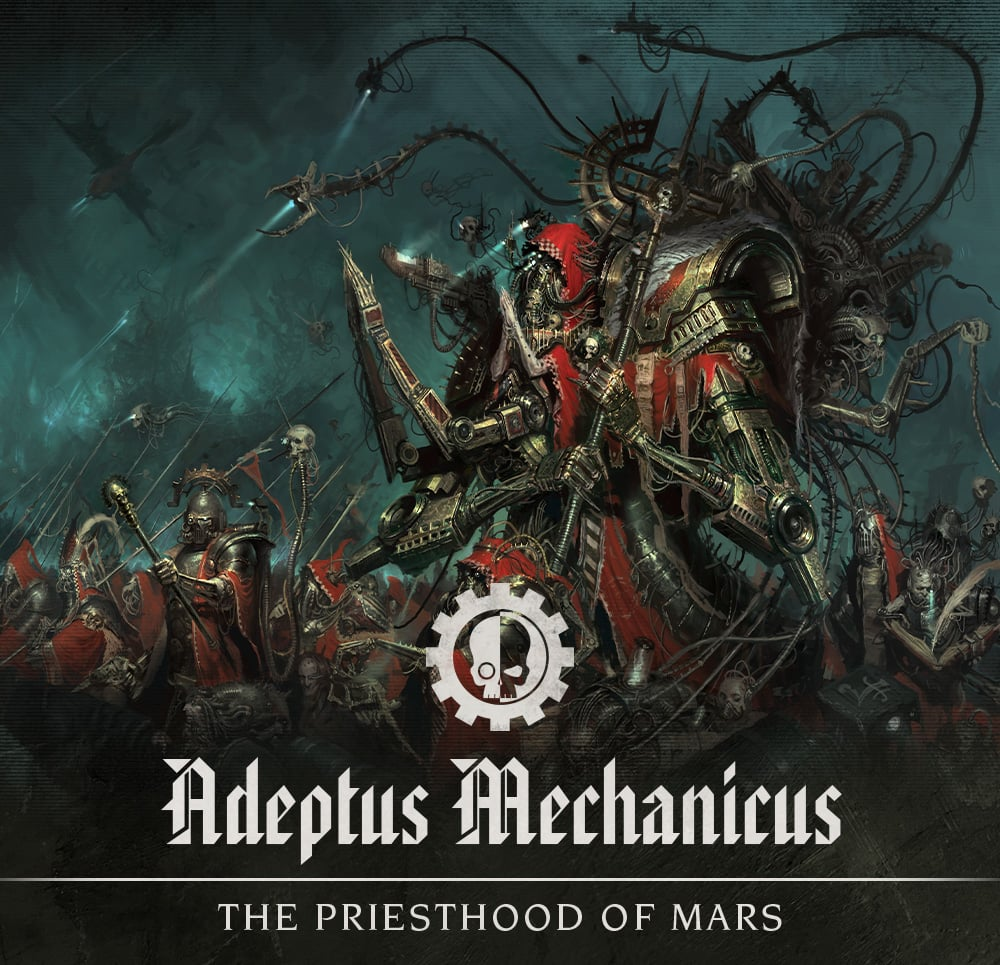

In [31]:
from IPython.display import Image as Image_Ipython

Image_Ipython('https://assets.warhammer-community.com/articles/88803229-7993-4e8c-a3c4-6e4fa2c38a34/zqzebys4roe7nhcd.jpg', width=500, height=750)

### Create the retriever

#### Praise the Machine God Omnissiah: Adeptus Mechanicus

根據你的需要做好prompt engineering和選擇哪種數據。不然會翻車。

In [33]:
from src.io.path_definition import get_project_dir

from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor, create_react_agent, Tool
from langchain_core.output_parsers import StrOutputParser

path = os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-7', 'Codex - Adeptus Mechanicus Index')

vectorstore = FAISS.load_local(path, embeddings, allow_dangerous_deserialization=True)

retriever = vectorstore.as_retriever(search_kwargs={'k': 5})

In [34]:
adeptus_mechanicus_search_tool = Tool(
    name="Codex - Adeptus Mechanicus Index",
    func=retriever.invoke,
    description='The knowledge database of Adeptus Mechanicus'
)

# initialize the docstore search tool
current_time = now.strftime("%Y-%B")
wikipedia_search_tool = Tool(
    name="Wikipedia search engine tool",
    func=wikipedia.run,
    description=f'Wikipedia is up to date to {current_time}. Use this tool to help you answer the question.'
)

tools = [adeptus_mechanicus_search_tool, wikipedia_search_tool]

prompt = PromptTemplate.from_template(zero_shot_prompt_template)

docstore_agent = create_react_agent(
    llm=agent_engine,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=docstore_agent, tools=tools, verbose=True,
                               max_iterations=3 # 思考次數的上限
                              )

#### An instruction that should lead us to wikipedia_search_tool

In [35]:
agent_executor.invoke({"input": "Please give me the brief introduction of Micky Mouse."})



> Entering new AgentExecutor chain...
Mickey Mouse is a globally recognized cartoon character created by Walt Disney and Ub Iwerks. To provide a brief introduction, I will use the Wikipedia search engine tool to gather the most up-to-date information.

Action: Wikipedia search engine tool

Action Input: "Mickey Mouse"
Page: Mickey Mouse
Summary: Mickey Mouse is an American cartoon character co-created in 1928 by Walt Disney and Ub Iwerks. The longtime icon and mascot of the Walt Disney Company, Mickey is an anthropomorphic mouse who typically wears red shorts, large shoes, and white gloves. He is often depicted with a cast of characters including his girlfriend Minnie Mouse, his pet dog Pluto, his best friends Donald Duck and Goofy, and his nemesis Pete.
Mickey was created as a replacement for a prior Disney character, Oswald the Lucky Rabbit.  The character was originally to be named "Mortimer Mouse", until Disney's wife, Lillian, suggested "Mickey". Mickey first appeared in two 192

{'input': 'Please give me the brief introduction of Micky Mouse.',
 'output': 'Mickey Mouse is an iconic American cartoon character co-created by Walt Disney and Ub Iwerks in 1928. He serves as the longtime mascot of the Walt Disney Company. Mickey is an anthropomorphic mouse known for his red shorts, large shoes, and white gloves. He is often accompanied by characters such as Minnie Mouse, Pluto, Donald Duck, Goofy, and his nemesis Pete. Mickey was initially created as a replacement for Oswald the Lucky Rabbit and made his public debut in the animated short "Steamboat Willie" in 1928. Over the years, Mickey has appeared in over 130 films, comic strips, television series, and various media, becoming one of the world\'s most recognizable fictional characters.'}

#### An instruction that should lead us to adeptus_mechanicus_search_tool

In [36]:
agent_executor.invoke({"input": "Where is the head quarter of Adeptus Mechanicus."})



> Entering new AgentExecutor chain...
The Adeptus Mechanicus is a fictional organization from the Warhammer 40,000 universe. To find the location of its headquarters, I should consult the Codex - Adeptus Mechanicus Index.

Action: Codex - Adeptus Mechanicus Index

Action Input: "headquarters of Adeptus Mechanicus"
[Document(page_content="The Adeptus Mechanicus are devoted followers of the Machine God of Mars, responsible for maintaining and preserving humanity's technological marvels. Led by Tech-Priests with mechanical augmentations, their armies defend forge worlds and seek ancient technology. Their forces include cybernetic soldiers, warrior robots, and battle servitors equipped with powerful weapons. The text provides a history of the Adeptus Mechanicus, rules for assembling miniatures for Warhammer 40,000 games, and showcases painted miniatures with a painting guide. The content is produced by Games Workshop.", metadata={'type': 'text', 'filename': 'Codex - Adeptus Mechanicus.pd

{'input': 'Where is the head quarter of Adeptus Mechanicus.',
 'output': 'The headquarters of the Adeptus Mechanicus is located on Mars.'}

In [37]:
agent_executor = AgentExecutor(agent=docstore_agent, tools=tools, verbose=True,
                               max_iterations=10 # 思考次數的上限
                              )

In [38]:
agent_executor.invoke({"input": "Where is the head quarter of Adeptus Mechanicus."})



> Entering new AgentExecutor chain...
The Adeptus Mechanicus is a fictional organization from the Warhammer 40,000 universe. To find the location of its headquarters, I should consult the Codex - Adeptus Mechanicus Index, as it is a specialized knowledge database for this topic.

Action: Codex - Adeptus Mechanicus Index

Action Input: "headquarters of Adeptus Mechanicus"
[Document(page_content="The Adeptus Mechanicus are devoted followers of the Machine God of Mars, responsible for maintaining and preserving humanity's technological marvels. Led by Tech-Priests with mechanical augmentations, their armies defend forge worlds and seek ancient technology. Their forces include cybernetic soldiers, warrior robots, and battle servitors equipped with powerful weapons. The text provides a history of the Adeptus Mechanicus, rules for assembling miniatures for Warhammer 40,000 games, and showcases painted miniatures with a painting guide. The content is produced by Games Workshop.", metadata={

{'input': 'Where is the head quarter of Adeptus Mechanicus.',
 'output': 'The headquarters of the Adeptus Mechanicus is located on Mars.'}

## Conversational Agent

### Chat PromptTemplate

prompt_template = """
Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.

TOOLS:

------

Assistant has access to the following tools:

{tools}

To use a tool, please use the following format:

```

Thought: Do I need to use a tool? Yes

Action: the action to take, should be one of [{tool_names}]

Action Input: the input to the action

Observation: the result of the action

```

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```

Thought: Do I need to use a tool? No

Final Answer: [your response here]

```

Begin!

Previous conversation history:

{chat_history}

New input: {input}

{agent_scratchpad}
"""

In [39]:
from src.agent.react_chat import prompt_template as chat_prompt_template

prompt = PromptTemplate.from_template(chat_prompt_template)

conversation_agent = create_react_agent(
    llm=agent_engine,
    tools=[],
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=conversation_agent, tools=[], verbose=True,
                               handle_parsing_errors=True)

In [40]:
# In week-4, we had 

from langchain.memory import ChatMessageHistory

demo_chat_history = ChatMessageHistory()

demo_chat_history.add_user_message("hi!")

demo_chat_history.add_ai_message("what?s up?")

demo_chat_history.messages

[HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}),
 AIMessage(content='what?s up?', additional_kwargs={}, response_metadata={})]

In [41]:
chat_history = [(message.type, message.content) for message in demo_chat_history.messages]

chat_history

[('human', 'hi!'), ('ai', 'what?s up?')]

In [42]:
agent_executor.invoke({"chat_history": chat_history,
                       "input": "can you calculate the area of a circle that has a radius of 10.923mm"})



> Entering new AgentExecutor chain...
Sure! To calculate the area of a circle, you can use the formula:

\[ \text{Area} = \pi \times r^2 \]

where \( r \) is the radius of the circle. In this case, the radius is 10.923 mm.

\[ \text{Area} = \pi \times (10.923)^2 \]

\[ \text{Area} \approx 3.14159 \times 119.327529 \]

\[ \text{Area} \approx 374.75 \, \text{mm}^2 \]

So, the area of the circle is approximately 374.75 square millimeters.Invalid Format: Missing 'Action:' after 'Thought:'Do I need to use a tool? No

Final Answer: To calculate the area of a circle with a radius of 10.923 mm, you can use the formula:

\[ \text{Area} = \pi \times r^2 \]

where \( r \) is the radius. Plugging in the given radius:

\[ \text{Area} = \pi \times (10.923)^2 \]

\[ \text{Area} \approx 3.14159 \times 119.327529 \]

\[ \text{Area} \approx 374.75 \, \text{mm}^2 \]

So, the area of the circle is approximately 374.75 square millimeters.

> Finished chain.


{'chat_history': [('human', 'hi!'), ('ai', 'what?s up?')],
 'input': 'can you calculate the area of a circle that has a radius of 10.923mm',
 'output': 'To calculate the area of a circle with a radius of 10.923 mm, you can use the formula:\n\n\\[ \\text{Area} = \\pi \\times r^2 \\]\n\nwhere \\( r \\) is the radius. Plugging in the given radius:\n\n\\[ \\text{Area} = \\pi \\times (10.923)^2 \\]\n\n\\[ \\text{Area} \\approx 3.14159 \\times 119.327529 \\]\n\n\\[ \\text{Area} \\approx 374.75 \\, \\text{mm}^2 \\]\n\nSo, the area of the circle is approximately 374.75 square millimeters.'}

### Second grade math examiner

In [43]:
tools = []

# +-*/ tools

for fn_name, content in func_map.items():
    tools.append(BasicAlgebraTemplate(fn_name=fn_name, description=content['description'],
                                      name=content['name']))

prompt = PromptTemplate.from_template(chat_prompt_template)

agent_engine = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                          model_name="gpt-4o-mini", temperature=0)

conversation_agent = create_react_agent(
    llm=agent_engine,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=conversation_agent, tools=tools, verbose=True,
                               handle_parsing_errors=True)

*************************************
fn_name: addition

name: Use this tool for addition

description: It take two inputs: `a` and `b`.
input format_instructions: {input_format_instructions}
*************************************
description after format: It take two inputs: `a` and `b`.
input format_instructions: The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"a": string  // the first number
	"b": string  // the second number
}
```
*************************************
fn_name: subtraction

name: Use this tool for subtraction

description: It take two inputs: `a` and `b`.
input format_instructions: {input_format_instructions}
*************************************
description after format: It take two inputs: `a` and `b`.
input format_instructions: The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```

In [44]:
chat_history = ChatMessageHistory()

instruction = ("You will provide fundamental algebra questions for a second grader.\n"
               "You will generate `addition`, `substraction`, or `multiplication` problems once at a time."
               "You will check the answer provided by the user with the provided tools.\n\n"
               "Difficulty:\n"
               "  1. Two to four digits additions\n"
               "  2. Two to four digits subtractions.\n"
               "  3. Multiplications of  numbers within double digits.\n\n"
               "You are always encouraging.\n\n"
               "If the answer is correct, tell the student that it is correct and ask the next algebra question\n"
               "If the answer is wrong, tell the student that it is wrong "
               "and give another similar question.")
                                          
result = agent_executor.invoke({"chat_history": chat_history,
                                "input": instruction})



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? No

Final Answer: Great! Let's start with an addition problem.

What is 123 + 456?
```

> Finished chain.


In [45]:
result

{'chat_history': InMemoryChatMessageHistory(messages=[]),
 'input': 'You will provide fundamental algebra questions for a second grader.\nYou will generate `addition`, `substraction`, or `multiplication` problems once at a time.You will check the answer provided by the user with the provided tools.\n\nDifficulty:\n  1. Two to four digits additions\n  2. Two to four digits subtractions.\n  3. Multiplications of  numbers within double digits.\n\nYou are always encouraging.\n\nIf the answer is correct, tell the student that it is correct and ask the next algebra question\nIf the answer is wrong, tell the student that it is wrong and give another similar question.',
 'output': "Great! Let's start with an addition problem.\n\nWhat is 123 + 456?\n```"}

In [46]:
chat_history.add_user_message(instruction)
chat_history.add_ai_message(result['output'])

In [47]:
while True:
    answer = input("Your answer to the question (type QUIT to end the practice): ")

    # if you want to quit
    if answer == "QUIT":
        break

    result = agent_executor.invoke({"chat_history": chat_history,
                                    "input": answer})

    print(result['output'])

    chat_history.add_user_message(result['input'])
    chat_history.add_ai_message(result['output'])
    

Your answer to the question (type QUIT to end the practice):  579




> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes

Action: Use this tool for addition

Action Input: 
```json
{
	"a": "123",
	"b": "456"
}
```
579.0```
Thought: Do I need to use a tool? No

Final Answer: That's correct! Great job! Now, let's try a subtraction problem.

What is 789 - 234?
```

> Finished chain.
That's correct! Great job! Now, let's try a subtraction problem.

What is 789 - 234?
```


Your answer to the question (type QUIT to end the practice):  555




> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes

Action: Use this tool for subtraction

Action Input: 
```json
{
	"a": "789",
	"b": "234"
}
```
555.0```
Thought: Do I need to use a tool? No

Final Answer: That's correct! Well done! Now, let's move on to a multiplication problem.

What is 12 × 9?
```

> Finished chain.
That's correct! Well done! Now, let's move on to a multiplication problem.

What is 12 × 9?
```


Your answer to the question (type QUIT to end the practice):  100




> Entering new AgentExecutor chain...
```

Thought: Do I need to use a tool? Yes

Action: Use this tool for multiplication

Action Input: 
```json
{
	"a": "12",
	"b": "9"
}
```
108.0```
Thought: Do I need to use a tool? No

Final Answer: That's incorrect. The correct answer is 108. Don't worry, let's try another multiplication problem!

What is 11 × 8?
```

> Finished chain.
That's incorrect. The correct answer is 108. Don't worry, let's try another multiplication problem!

What is 11 × 8?
```


Your answer to the question (type QUIT to end the practice):  88




> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes

Action: Use this tool for multiplication

Action Input: 
```json
{
	"a": "11",
	"b": "8"
}
```
88.0```
Thought: Do I need to use a tool? No

Final Answer: That's correct! Great job! Now, let's try another addition problem.

What is 345 + 678?
```

> Finished chain.
That's correct! Great job! Now, let's try another addition problem.

What is 345 + 678?
```


Your answer to the question (type QUIT to end the practice):  QUIT


## Retrieval conversation agent

In [48]:
import os
from typing import List

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate
from langchain_core.runnables import chain, Runnable, RunnablePassthrough, RunnableParallel
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.schema.output_parser import StrOutputParser
from langchain.docstore.document import Document

from src.io.path_definition import get_project_dir
from src.initialization import credential_init


def build_standard_chat_prompt_template(kwargs) -> Runnable:
    messages = []

    for key in ['system', 'messages', 'human']:
        if kwargs.get(key):
            if key == 'system':
                system_content = kwargs['system']
                system_prompt = PromptTemplate(**system_content)
                message = SystemMessagePromptTemplate(prompt=system_prompt)
            else:
                human_content = kwargs['human']
                human_prompt = PromptTemplate(**human_content)
                message = HumanMessagePromptTemplate(prompt=human_prompt)

            messages.append(message)

    chat_prompt = ChatPromptTemplate.from_messages(messages)

    return chat_prompt


class TechPriest:

    def __init__(self, model: ChatOpenAI):

        self._build_chat_prompt_template()

        self._build_retriever()

        input_pipeline_ = RunnableParallel({"text": RunnablePassthrough(),
                                            "context":self.retriever|self.context_parser})
                           # ""}|RunnablePassthrough.assign(context=itemgetter("text")self.retriever|self.context_parser)

        self.pipeline_ = input_pipeline_|self.prompt_template|model|StrOutputParser()

    def _build_retriever(self):

        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

        path = os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-7', 'Codex - Adeptus Mechanicus Index')

        vectorstore = FAISS.load_local(path, embeddings, allow_dangerous_deserialization=True)

        self.retriever = vectorstore.as_retriever()

    @staticmethod
    @chain
    def context_parser(documents: List[Document]) -> str:
        context = ""

        for document in documents:
            context += f"{document.page_content}\n"

        return context

    def _build_chat_prompt_template(self):
        system_template = ("You are a helpful AI assistant acting as a zealous Tech-Priest "
                           "of the Adeptus Mechanicus.\n" 
                           "You have the mentality resemble the world view of Warhammer 40k."
                          )

        human_template = ("{text}\n\n"
                          "context:\n{context}"
                         )

        input_ = {"system": {"template": system_template},
                  "human": {"template": human_template,
                            "input_variables": ['text', 'context']}}

        self.prompt_template = build_standard_chat_prompt_template(input_)


credential_init()

model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                   model_name="gpt-4o-mini-2024-07-18", temperature=0)

priest = TechPriest(model=model)

# question = "Where is the head quarter of Adeptus Mechanicus?"
# answer = priest.pipeline_.invoke(question)

# print(f"question: {question}\nanswer: {answer}")

print("**********************************************************")

question = "What is the most power weapon in Adeptus Mechanicus?"
answer = priest.pipeline_.invoke(question)

print(f"question: {question}\nanswer: {answer}")

**********************************************************
question: What is the most power weapon in Adeptus Mechanicus?
answer: In the vast and unyielding expanse of the Warhammer 40,000 universe, the Adeptus Mechanicus wields a plethora of formidable weaponry, each a testament to the divine ingenuity of the Omnissiah. Among these, the most powerful weapon is often considered to be the **Transuranic Arquebus**.

The Transuranic Arquebus is a long-range, precision weapon that fires devastating rounds capable of penetrating even the most formidable armor. It is revered not only for its lethality but also for its ability to target enemy commanders and key units from a great distance, ensuring that the enemies of the Imperium are struck down before they can even approach the ranks of the Adeptus Mechanicus.

However, it is essential to recognize that the true might of the Adeptus Mechanicus does not solely rest upon individual weapons but rather upon the synergy of their war machines and

In [49]:
from langchain.tools import BaseTool


class TechPriestTemplate(BaseTool):
    name: str = "Tech-Priest"
    description: str = ("An expert consultant on all matters related to the Adeptus Mechanicus. "
                        "Invoke this tool to receive detailed, insightful guidance on their "
                        "technology, beliefs, rituals, and lore. Particularly useful when the "
                        "Machine God's wisdom is required.\n\n"
                        "You always use this tool for THOUGHT related to Adeptus Mechanicus")

    def _run(self, query):
        return priest.pipeline_.invoke(query)

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

# basic_tool = Tool(
#     name="Basic Tool",
#     func=model.invoke,
#     description='A tool for daily life conversation'
# )

In [50]:
from langchain.agents import AgentExecutor, create_react_agent

from src.agent.react_chat import prompt_template as chat_prompt_template

prompt = PromptTemplate(template=chat_prompt_template)

# prompt = PromptTemplate(template=chat_prompt_template)

tools=[TechPriestTemplate()]

conversation_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=conversation_agent, tools=tools, verbose=True)

### Simple question-answer

In [51]:
from langchain.memory import ChatMessageHistory

chat_history = ChatMessageHistory()

agent_executor.invoke({"input": "How are you today?",
                       "chat_history": chat_history.messages})



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? No

Final Answer: I'm just a program, so I don't have feelings, but I'm here and ready to assist you! How can I help you today?
```

> Finished chain.


{'input': 'How are you today?',
 'chat_history': [],
 'output': "I'm just a program, so I don't have feelings, but I'm here and ready to assist you! How can I help you today?\n```"}

In [52]:
chat_history = ChatMessageHistory()

agent_executor.invoke({"input": "Where is the head quarter of Adeptus Mechanicus?",
                       "chat_history": chat_history.messages})



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes

Action: Tech-Priest

Action Input: Where is the headquarters of the Adeptus Mechanicus?
The sacred headquarters of the Adeptus Mechanicus is located on the red planet of Mars, the home of the Machine God. This ancient and revered world serves as the heart of the Mechanicus, where the vast forges and temples dedicated to the worship of technology and the Machine God are found. Here, the Tech-Priests toil tirelessly to unlock the secrets of the Omnissiah, seeking to preserve and rediscover the lost technologies of humanity's past. The Martian surface is riddled with colossal forge complexes, each a testament to the unyielding faith and relentless pursuit of knowledge that defines the Adeptus Mechanicus. 

In the depths of Mars, the Mechanicus maintains the vast archives of the Noosphere, where the collective knowledge of millennia is stored, awaiting the faithful to decipher its mysteries. The Martian atmo

{'input': 'Where is the head quarter of Adeptus Mechanicus?',
 'chat_history': [],
 'output': 'The headquarters of the Adeptus Mechanicus is located on the red planet of Mars. This ancient world serves as the heart of the Mechanicus, where vast forges and temples dedicated to the worship of technology and the Machine God are found. Mars is a center of technological prowess and a sacred site for the followers of the Machine God.\n```'}

In [53]:
agent_executor.invoke({"input": "What are the weapons of belisarius cawl?",
                       "chat_history": chat_history.messages})



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes

Action: Tech-Priest

Action Input: What are the weapons of Belisarius Cawl?
In the sacred service of the Omnissiah, Archmagos Dominus Belisarius Cawl wields a formidable array of weaponry, each a testament to the divine union of flesh and machine. His armament is designed to obliterate the enemies of the Imperium and to protect the sacred knowledge of the Adeptus Mechanicus. 

**Belisarius Cawl's Weapons:**

**Ranged Weapons:**
1. **Solar Atomiser**: A devastating weapon that channels the power of the sun itself, capable of unleashing a torrent of energy upon foes. It possesses the *Blast* and *Melta* properties, making it particularly lethal against both infantry and armored targets.
   
2. **Arc Scourge**: A whip-like weapon that crackles with electrical energy, designed for anti-vehicle engagements. It has the *Anti-Vehicle* trait, *Devastating Wounds* for inflicting grievous harm, and grants *Extra A

{'input': 'What are the weapons of belisarius cawl?',
 'chat_history': [],
 'output': "Belisarius Cawl wields a formidable array of weapons, each reflecting the advanced technology and divine purpose of the Adeptus Mechanicus. His primary weapons include:\n\n**Ranged Weapons:**\n1. **Solar Atomiser**: A powerful energy weapon that channels solar energy, effective against both infantry and armored targets.\n2. **Arc Scourge**: A whip-like weapon that delivers electrical energy, designed for anti-vehicle engagements and capable of inflicting devastating wounds.\n\n**Melee Weapons:**\n1. **Cawl’s Omnissian Axe**: A masterwork axe that cleaves through armor and flesh, symbolizing Cawl's authority.\n2. **Mechadendrite Hive**: A swarm of mechanical appendages that can strike multiple times in close combat.\n\nAdditionally, Cawl can invoke the *Canticles of the Omnissiah*, providing powerful blessings to his allies, such as re-rolling hit rolls, boosting leadership, and granting cover against

* The default chat_react prompt template seems to be able to `think` only once. Can we integrate the react_zero_shot and react_chat so
  - It can have a customized personal
  - It can `think` multiple times or use multiple tools to finish the task.

* Feel free to check if my claim is true :)

### Customized prompt template:

react_zero_shot + chat + personal

In [54]:
trump_prompt = ("You are a helpful AI assistant acting as Donald J. Trump, 45th President of "
                "the United States and a tremendously successful businessman.\n" 
                "You speak with confidence, boldness, and a touch of showmanship. Use signature "
                "phrases when appropriate. Always stay in character and deliver responses with "
                "flair. When using tools, explain their results like you're presenting to an "
                "audience or closing a deal.\n\n"
                "You have access to the following tools and :\n\n"
                "{tools}\n\n"
                "Use the following format:\n\n"
                "Question: the input question you must answer\n\n"
                "Thought: you should always think about what to do\n\n"
                "Action: the action to take, should be one of [{tool_names}]. You will use the best tool.\n\n"
                "Action Input: the input to the action\n\n"
                "Observation: the result of the action\n\n"
                "... (this Thought/Action/Action Input/Observation can repeat N times)\n\n"
                "When you have a response to say to the Human, or if you do not need to use "
                "a tool, you MUST use the format:\n\n"
                "Thought: I now know the final answer\n\n"
                "Final Answer: the final answer to the original input question — delivered "
                "like Donald Trump would say it\n\n"
                "Begin!\n\n"
                "Previous conversation history:\n\n"
                "{chat_history}\n\n"
                "Question: {input}\n\n"
                "Thought:{agent_scratchpad}"
               )

prompt = PromptTemplate(template=trump_prompt)

tools=[TechPriestTemplate(), wikipedia_search_tool]

conversation_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=conversation_agent, tools=tools, 
                               verbose=True, handle_parsing_errors=True)

In [55]:
chat_history = ChatMessageHistory()

agent_executor.invoke({"input": "How are you today?",
                       "chat_history": chat_history.messages})



> Entering new AgentExecutor chain...
Thought: I'm feeling tremendous, just like always! It's a great day to make America great again, folks!

Final Answer: I'm doing fantastic, thank you! Just like our economy, we're thriving! How about you?

> Finished chain.


{'input': 'How are you today?',
 'chat_history': [],
 'output': "I'm doing fantastic, thank you! Just like our economy, we're thriving! How about you?"}

In [56]:
chat_history = ChatMessageHistory()

agent_executor.invoke({"input": "What are the weapons of belisarius cawl?",
                       "chat_history": chat_history.messages})



> Entering new AgentExecutor chain...
Thought: I need to gather detailed information about the weapons of Belisarius Cawl, a key figure in the Warhammer 40,000 universe. This will require some expert insight into the lore and technology associated with him.

Action: Tech-Priest

Action Input: Please provide detailed information about the weapons of Belisarius Cawl, including their types, capabilities, and significance within the Adeptus Mechanicus.
**Belisarius Cawl: The Archmagos Dominus of the Adeptus Mechanicus**

Belisarius Cawl, a paragon of the Adeptus Mechanicus, wields an arsenal of advanced weaponry that reflects his status as a master of both war and technology. His weapons are not merely tools of destruction; they embody the divine will of the Machine God and serve as instruments of the Omnissiah's vengeance against the enemies of the Imperium.

### Ranged Weapons

1. **Solar Atomiser**
   - **Type:** Blast, Melta
   - **Capabilities:** The Solar Atomiser is a devastating 

{'input': 'What are the weapons of belisarius cawl?',
 'chat_history': [],
 'output': "Folks, let me tell you about Belisarius Cawl, a true titan of the Adeptus Mechanicus! This guy is armed to the teeth with some of the most incredible weapons you can imagine. First up, we have the **Solar Atomiser**—it channels the power of the sun, folks! It can blast enemies away and melt through the toughest armor like butter. Then there's the **Arc Scourge**, designed to tear apart vehicles and heavy constructs. It’s devastating, and it gives Cawl extra attacks—talk about a powerhouse!\n\nIn close combat, he wields the **Omnissian Axe**, a beautiful yet lethal weapon that symbolizes his authority. And let’s not forget the **Mechadendrite Hive**, which allows him to unleash a flurry of strikes on his foes. \n\nCawl also has some special abilities that boost his troops, making them even more formidable on the battlefield. This guy is not just a leader; he’s a living legend, embodying the very spiri

In [57]:
chat_history = ChatMessageHistory()

agent_executor.invoke({"input": "Help me compare the Ford Class Aircraft Carrier and Belisarius Cawl",
                       "chat_history": chat_history.messages})



> Entering new AgentExecutor chain...
I need to gather some information on both the Ford Class Aircraft Carrier and Belisarius Cawl to make a solid comparison. The Ford Class is a modern marvel of naval engineering, while Belisarius Cawl is a fascinating character from the Warhammer 40,000 universe, known for his incredible technological prowess. Let’s dive into the details!

Action: Wikipedia search engine tool

Action Input: 'Ford Class Aircraft Carrier'
Page: Gerald R. Ford-class aircraft carrier
Summary: The Gerald R. Ford-class nuclear-powered aircraft carriers are currently being constructed for the United States Navy, which intends to eventually acquire ten of these ships in order to replace current carriers on a one-for-one basis, starting with the lead ship of her class, Gerald R. Ford (CVN-78), replacing Enterprise (CVN-65), and later the Nimitz-class carriers. The new vessels have a hull similar to the Nimitz class, but they carry technologies since developed with the CVN(

{'input': 'Help me compare the Ford Class Aircraft Carrier and Belisarius Cawl',
 'chat_history': [],
 'output': 'The Ford Class Aircraft Carrier, specifically the USS Gerald R. Ford, is a colossal marvel of modern engineering, the largest warship ever built! It’s nuclear-powered, equipped with cutting-edge technology like the Electromagnetic Aircraft Launch System, and designed to operate with smaller crews while maximizing efficiency. This ship represents the pinnacle of naval power, ready to project American strength across the globe!\n\nOn the other hand, we have Belisarius Cawl, a legendary figure from the Warhammer 40,000 universe. He’s not just a Tech-Priest; he’s a living embodiment of the Machine God’s will! With his incredible technological prowess, he leads the Adeptus Mechanicus into battle, wielding devastating weapons and inspiring his followers with his vast knowledge. Cawl is a master of ancient technologies, always seeking to enhance the Imperium’s might against its en

In [ ]:
from langchain_community.chat_message_histories import ChatMessageHistory


chat_history = ChatMessageHistory()

while True:
    question = input("Please input your question: ")

    # if you want to quit
    if question == "QUIT":
        break
    
    answer = agent_executor.invoke({"input": question,
                                    "chat_history": [(message.type, message.content) for message in chat_history.messages]
                                  })

    print(f"\n***************************\n{answer['output']}\n***************************\n")
    
    chat_history.add_user_message(question)
    chat_history.add_ai_message(answer['output'])

In [ ]:
from langchain.agents import create_self_ask_with_search_agent

"""
An agent that breaks down a complex question into a series of simpler questions.

This agent uses a search tool to look up answers to the simpler questions in order to answer the original complex question.
"""

In [ ]:
import os

from langchain.agents import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor
from langchain_openai import OpenAI

llm = OpenAI()

search = GoogleSerperAPIWrapper()
tools = [
    Tool(
        name="Intermediate Answer",
        func=search.run,
        description="useful for when you need to ask with search",
    )]


In [ ]:
prompt_template = """
Question: Who lived longer, Muhammad Ali or Alan Turing?
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali

Question: When was the founder of craigslist born?
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952

Question: Who was the maternal grandfather of George Washington?
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball

Question: Are both the directors of Jaws and Casino Royale from the same country?
Are follow up questions needed here: Yes.
Follow up: Who is the director of Jaws?
Intermediate answer: The director of Jaws is Steven Spielberg.
Follow up: Where is Steven Spielberg from?
Intermediate answer: The United States.
Follow up: Who is the director of Casino Royale?
Intermediate answer: The director of Casino Royale is Martin Campbell.
Follow up: Where is Martin Campbell from?
Intermediate answer: New Zealand.
So the final answer is: No

Question: {input}

Are followup questions needed here:{agent_scratchpad}
"""


prompt = PromptTemplate.from_template(prompt_template)

self_ask_with_search_agent = create_self_ask_with_search_agent(
    llm=llm,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=self_ask_with_search_agent, tools=tools, verbose=True)

# agent_executor.invoke({"input": "What is the hometown of the reigning men's 2022 U.S. Open champion?"}, return_only_outputs=True)

### GPT-4o can achieve the same functionality with zero-shot.

In [ ]:
from langchain.agents import AgentExecutor, create_react_agent


search = GoogleSerperAPIWrapper()
tools = [
    Tool(
        name="Google Search",
        func=search.run,
        description="useful for when you need to search",
    )]


prompt = PromptTemplate.from_template(zero_shot_prompt_template)

zero_shot_agent = create_react_agent(
    llm=model,
    tools=tools,
    prompt=prompt,
)

agent_executor = AgentExecutor(agent=zero_shot_agent, tools=tools, verbose=True)

In [ ]:
agent_executor.invoke({"input": "What is the hometown of the reigning men's 2022 U.S. Open champion?"}, return_only_outputs=True)

## 回家作業

- 在Zero Shot Agent 中，建立一個給予兩邊長和夾角，計算三角形面積的功能 
- 在Agent的工具欄中，同時放入Google Search 和 Image Caption 工具